## Part 2 - Data Preprocessing

In [12]:
from utils import load_data, get_class_mapping
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import wandb
import pandas as pd
import numpy as np

# Load and preprocess the data
df = load_data('MagicTelescope.arff', remove_outliers=False)


# Get class mapping if needed
class_mapping = get_class_mapping()

# Now you can proceed with your analysis
print(df.shape)
print(df.head())


Initial dataset shape: (18905, 11)
Columns: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
Final dataset shape: (18905, 11)
(18905, 11)
    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1  


### Data Pipeline and Splitting

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np

# Configuration
SPLIT_CONF = {
    'train_size': 0.7,
    'val_size': 0.15,
    'test_size': 0.15,
    'random_state': 42,
    'stratify': True
}

# Verify split sizes sum to 1.0
assert abs(SPLIT_CONF['train_size'] + SPLIT_CONF['val_size'] + SPLIT_CONF['test_size'] - 1.0) < 1e-6, \
    "Train, validation, and test sizes must sum to 1.0"

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

print(f"Total samples: {len(X)}")
print(f"Class distribution:\n{y.value_counts()}")
print(f"Class distribution (%):\n{y.value_counts(normalize=True) * 100}")

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=SPLIT_CONF['test_size'],
    random_state=SPLIT_CONF['random_state'],
    stratify=y if SPLIT_CONF['stratify'] else None
)

# Second split: separate train and validation from temp
val_size_adjusted = SPLIT_CONF['val_size'] / (SPLIT_CONF['train_size'] + SPLIT_CONF['val_size'])
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_adjusted,
    random_state=SPLIT_CONF['random_state'],
    stratify=y_temp if SPLIT_CONF['stratify'] else None
)

print(f"\nTrain set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nTrain class distribution:\n{y_train.value_counts()}")
print(f"Validation class distribution:\n{y_val.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")

Total samples: 18905
Class distribution:
class
1    12332
0     6573
Name: count, dtype: int64
Class distribution (%):
class
1    65.23142
0    34.76858
Name: proportion, dtype: float64

Train set: 13233 samples (70.0%)
Validation set: 2836 samples (15.0%)
Test set: 2836 samples (15.0%)

Train class distribution:
class
1    8632
0    4601
Name: count, dtype: int64
Validation class distribution:
class
1    1850
0     986
Name: count, dtype: int64
Test class distribution:
class
1    1850
0     986
Name: count, dtype: int64


In [14]:
# Define preprocessing pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold

# Choose preprocessing method
# PREPROCESSING_CONFIG = {
#     'method': 'power',  # Options: 'power', 'robust', 'standard', 'quantile'
#     'power_method': 'yeo-johnson',  # 'yeo-johnson' or 'box-cox'
#     'remove_low_variance': True,
#     'variance_threshold': 0.00
# }

PREPROCESSING_CONFIG = {
    'method': 'quantile',  # Options: 'power', 'robust', 'standard', 'quantile'
    'power_method': 'yeo-johnson',  # 'yeo-johnson' or 'box-cox'
    'remove_low_variance': True,
    'variance_threshold': 0.00
}

# Create preprocessing pipeline
def create_preprocessing_pipeline(config):
    """
    Create a sklearn preprocessing pipeline based on configuration.
    
    Parameters:
    -----------
    config : dict
        Configuration dictionary for preprocessing
    
    Returns:
    --------
    sklearn.pipeline.Pipeline
        Configured preprocessing pipeline
    """
    steps = []
    
    # Step 1: Remove low variance features (optional)
    if config['remove_low_variance']:
        steps.append(('variance_filter', VarianceThreshold(threshold=config['variance_threshold'])))
    
    # Step 2: Apply transformation
    if config['method'] == 'power':
        steps.append(('transformer', PowerTransformer(
            method=config['power_method'],
            standardize=True
        )))
    elif config['method'] == 'robust':
        steps.append(('transformer', RobustScaler()))
    elif config['method'] == 'standard':
        steps.append(('transformer', StandardScaler()))
    elif config['method'] == 'quantile':
        from sklearn.preprocessing import QuantileTransformer
        steps.append(('transformer', QuantileTransformer(
            output_distribution='normal',
            random_state=42
        )))
    else:
        raise ValueError(f"Unknown preprocessing method: {config['method']}")
    
    return Pipeline(steps)

# Create and fit pipeline on training data
preprocessing_pipeline = create_preprocessing_pipeline(PREPROCESSING_CONFIG)

print(f"Preprocessing pipeline: {PREPROCESSING_CONFIG['method']}")
print(f"Pipeline steps: {[step[0] for step in preprocessing_pipeline.steps]}")

# Fit on training data and transform all sets
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)
X_test_processed = preprocessing_pipeline.transform(X_test)

print(f"\nOriginal feature shape: {X_train.shape}")
print(f"Processed feature shape: {X_train_processed.shape}")

# Check for NaN or Inf values
print(f"\nTrain set - NaN: {np.isnan(X_train_processed).sum()}, Inf: {np.isinf(X_train_processed).sum()}")
print(f"Val set - NaN: {np.isnan(X_val_processed).sum()}, Inf: {np.isinf(X_val_processed).sum()}")
print(f"Test set - NaN: {np.isnan(X_test_processed).sum()}, Inf: {np.isinf(X_test_processed).sum()}")

Preprocessing pipeline: quantile
Pipeline steps: ['variance_filter', 'transformer']

Original feature shape: (13233, 10)
Processed feature shape: (13233, 10)

Train set - NaN: 0, Inf: 0
Val set - NaN: 0, Inf: 0
Test set - NaN: 0, Inf: 0


In [15]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)

X_val_tensor = torch.FloatTensor(X_val_processed)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test_processed)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

print(f"Train tensors: X={X_train_tensor.shape}, y={y_train_tensor.shape}")
print(f"Val tensors: X={X_val_tensor.shape}, y={y_val_tensor.shape}")
print(f"Test tensors: X={X_test_tensor.shape}, y={y_test_tensor.shape}")

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoader batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Verify a batch
sample_batch_X, sample_batch_y = next(iter(train_loader))
print(f"\nSample batch shapes: X={sample_batch_X.shape}, y={sample_batch_y.shape}")
print(f"Feature range in sample batch: [{sample_batch_X.min():.3f}, {sample_batch_X.max():.3f}]")

Train tensors: X=torch.Size([13233, 10]), y=torch.Size([13233, 1])
Val tensors: X=torch.Size([2836, 10]), y=torch.Size([2836, 1])
Test tensors: X=torch.Size([2836, 10]), y=torch.Size([2836, 1])

DataLoader batch size: 64
Train batches: 207
Val batches: 45
Test batches: 45

Sample batch shapes: X=torch.Size([64, 10]), y=torch.Size([64, 1])
Feature range in sample batch: [-2.944, 3.284]


### Vizualizations

VISUALIZING TRAINING SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


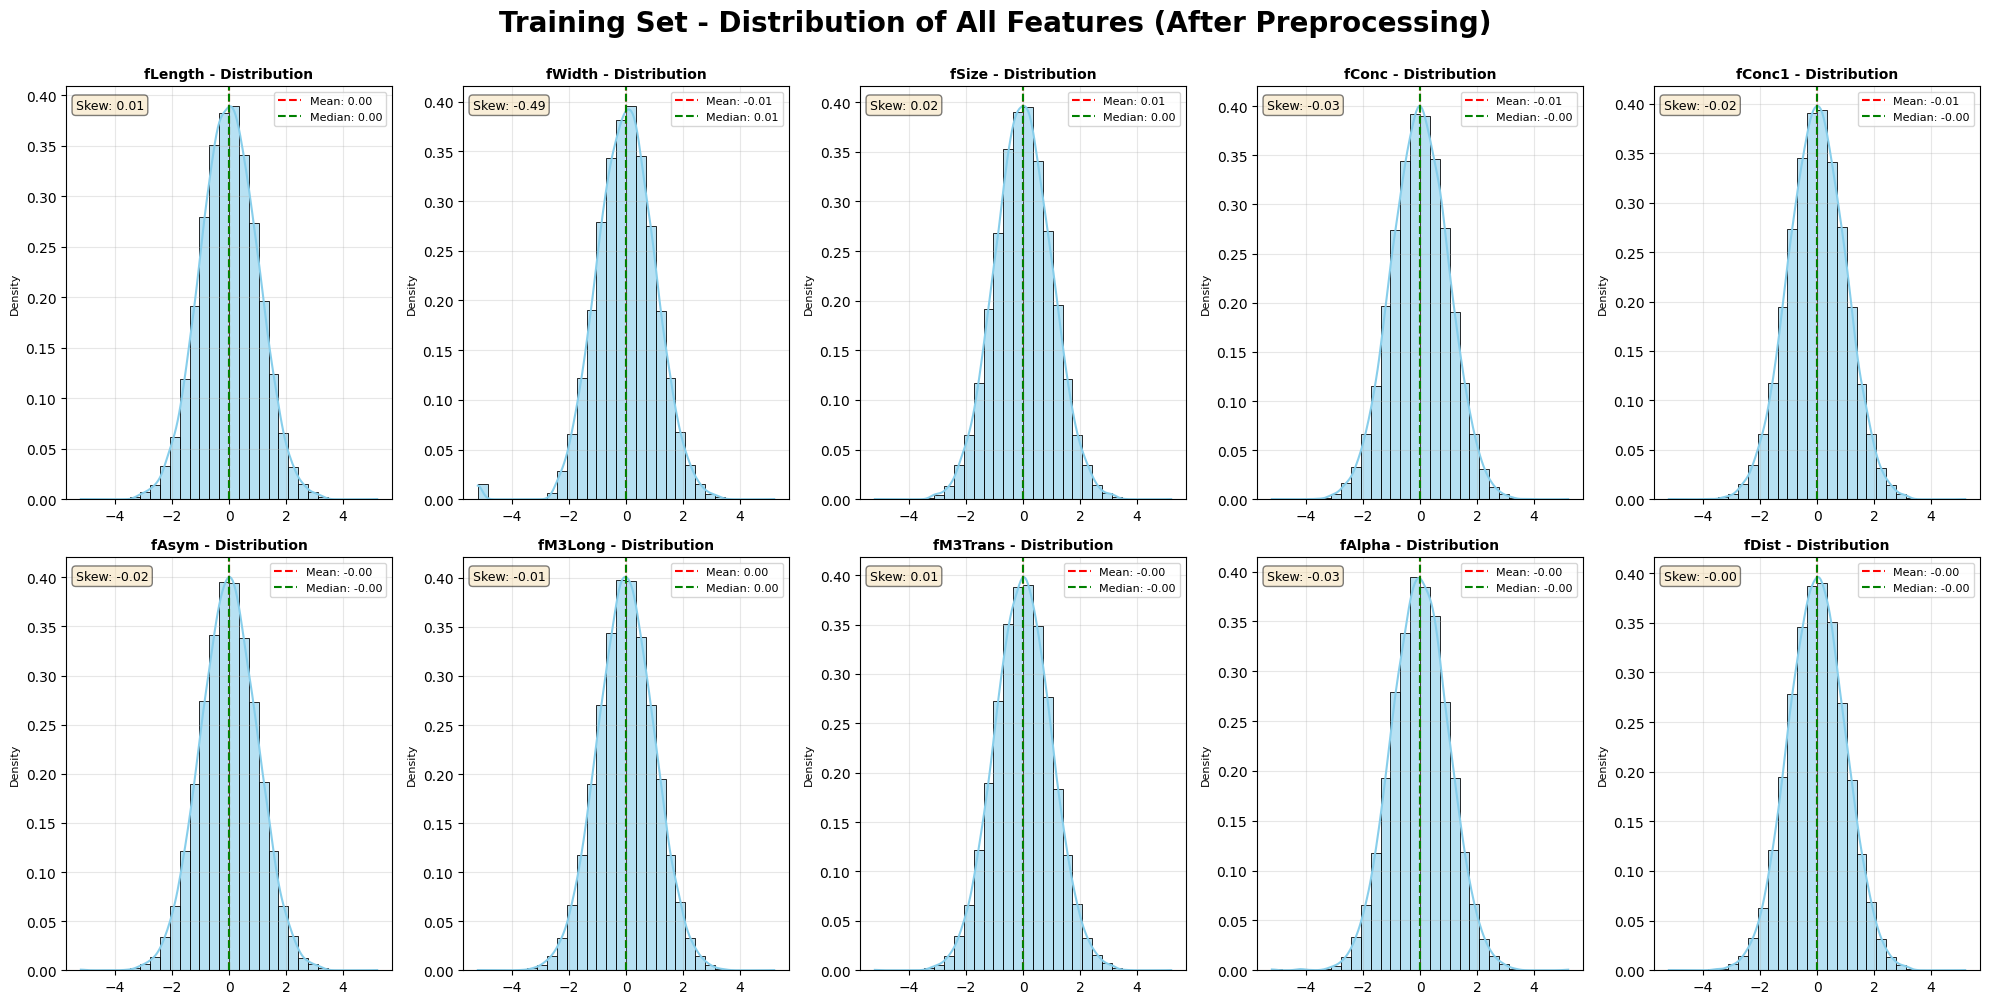

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


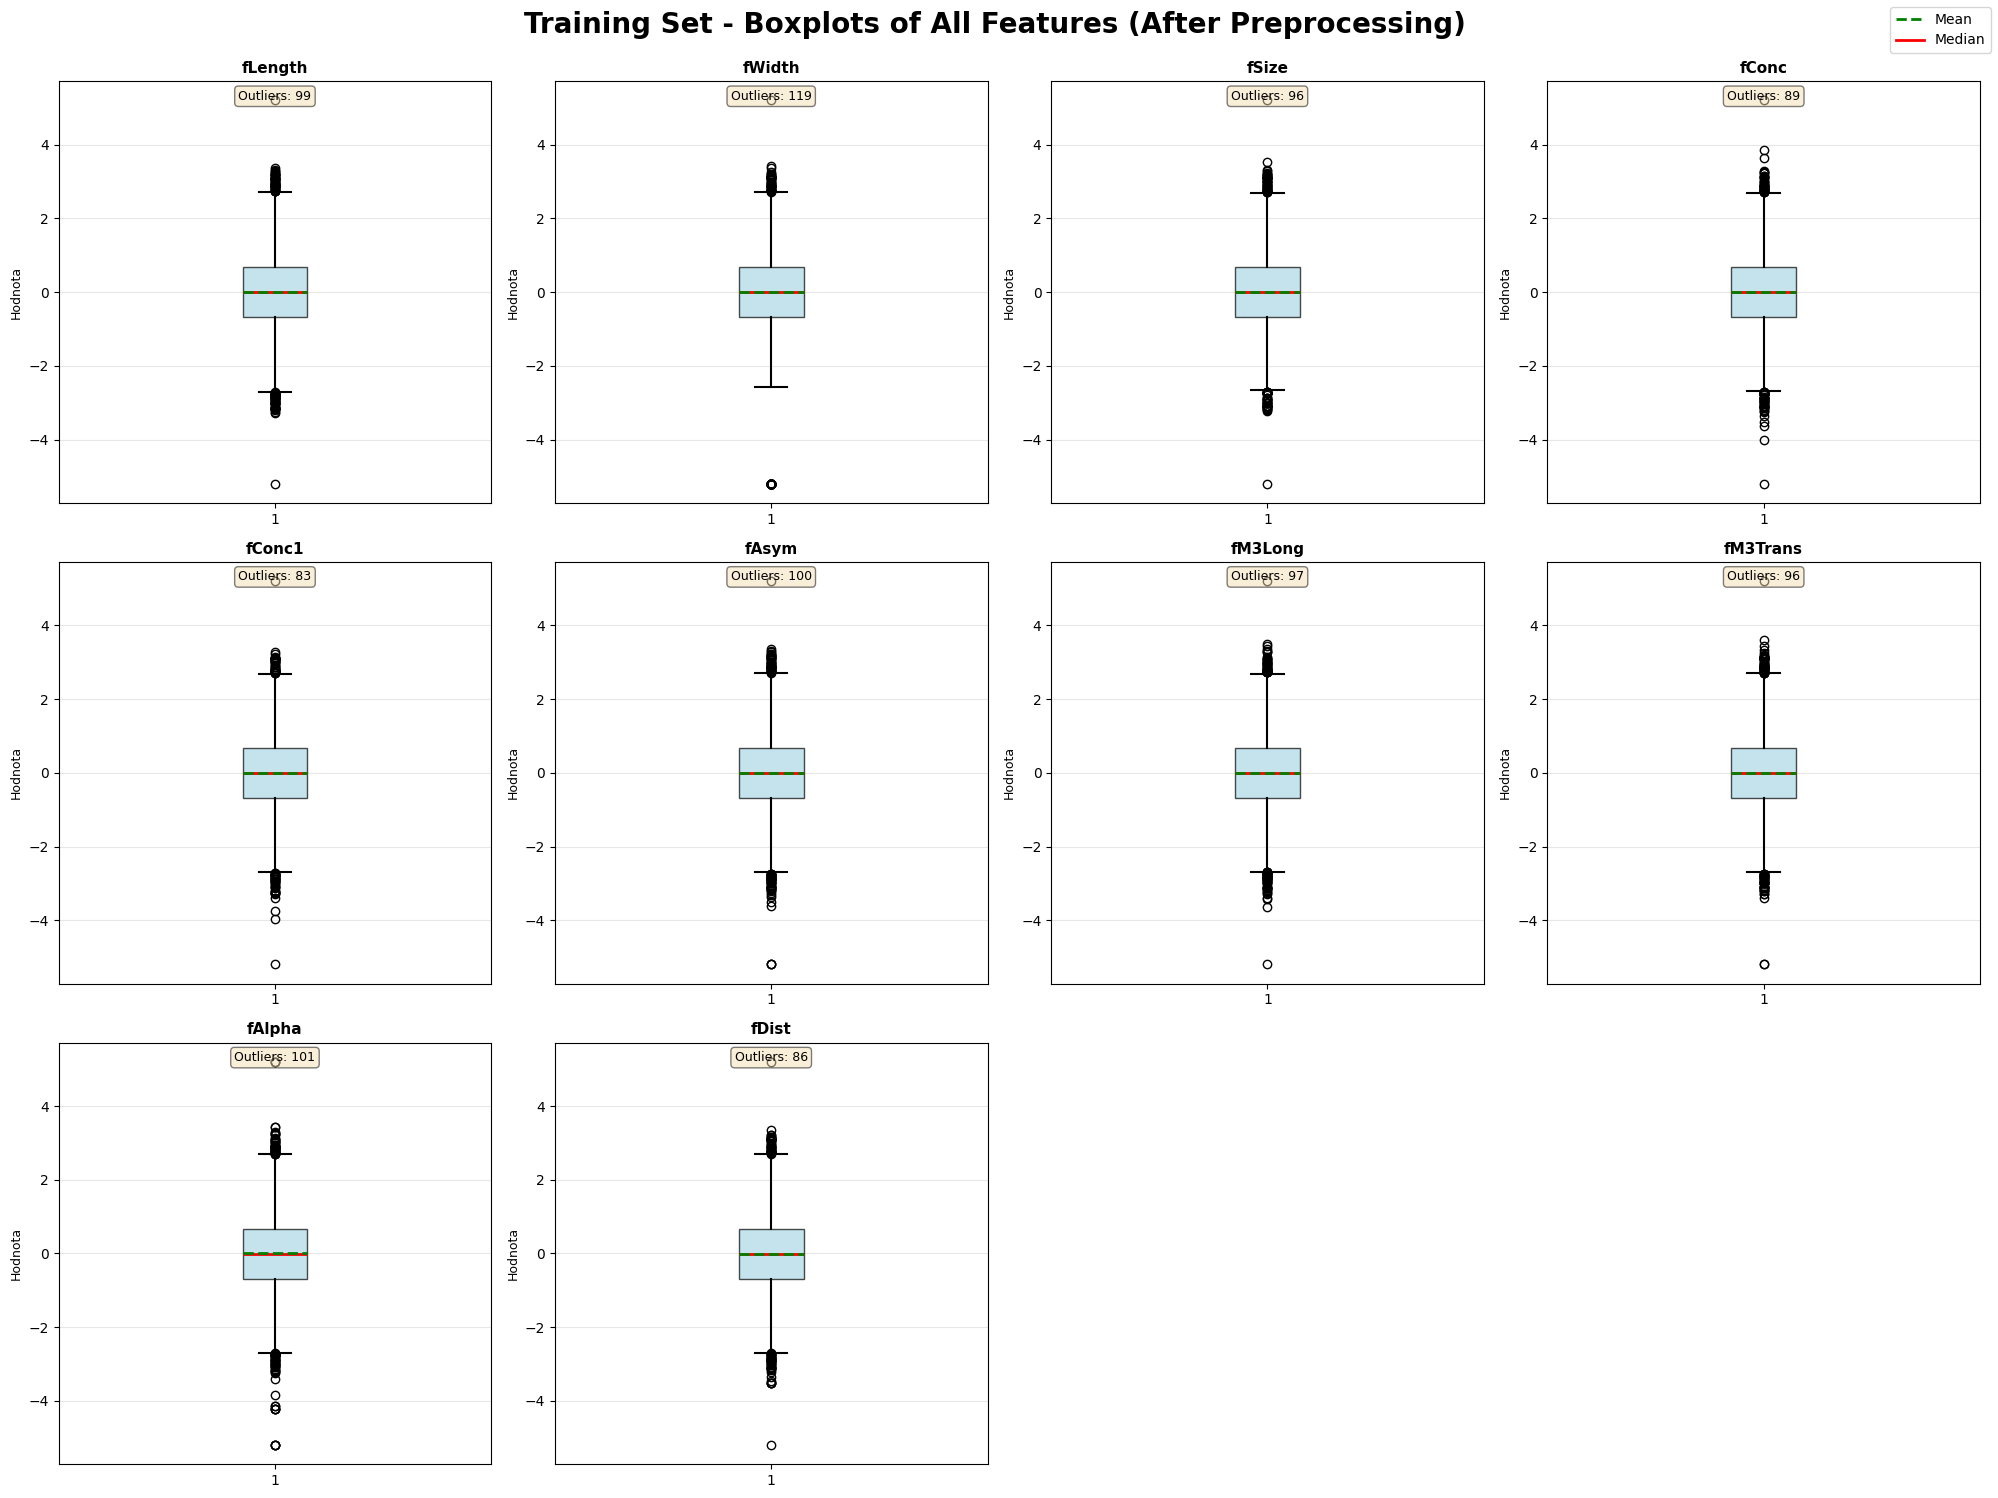


VISUALIZING VALIDATION SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


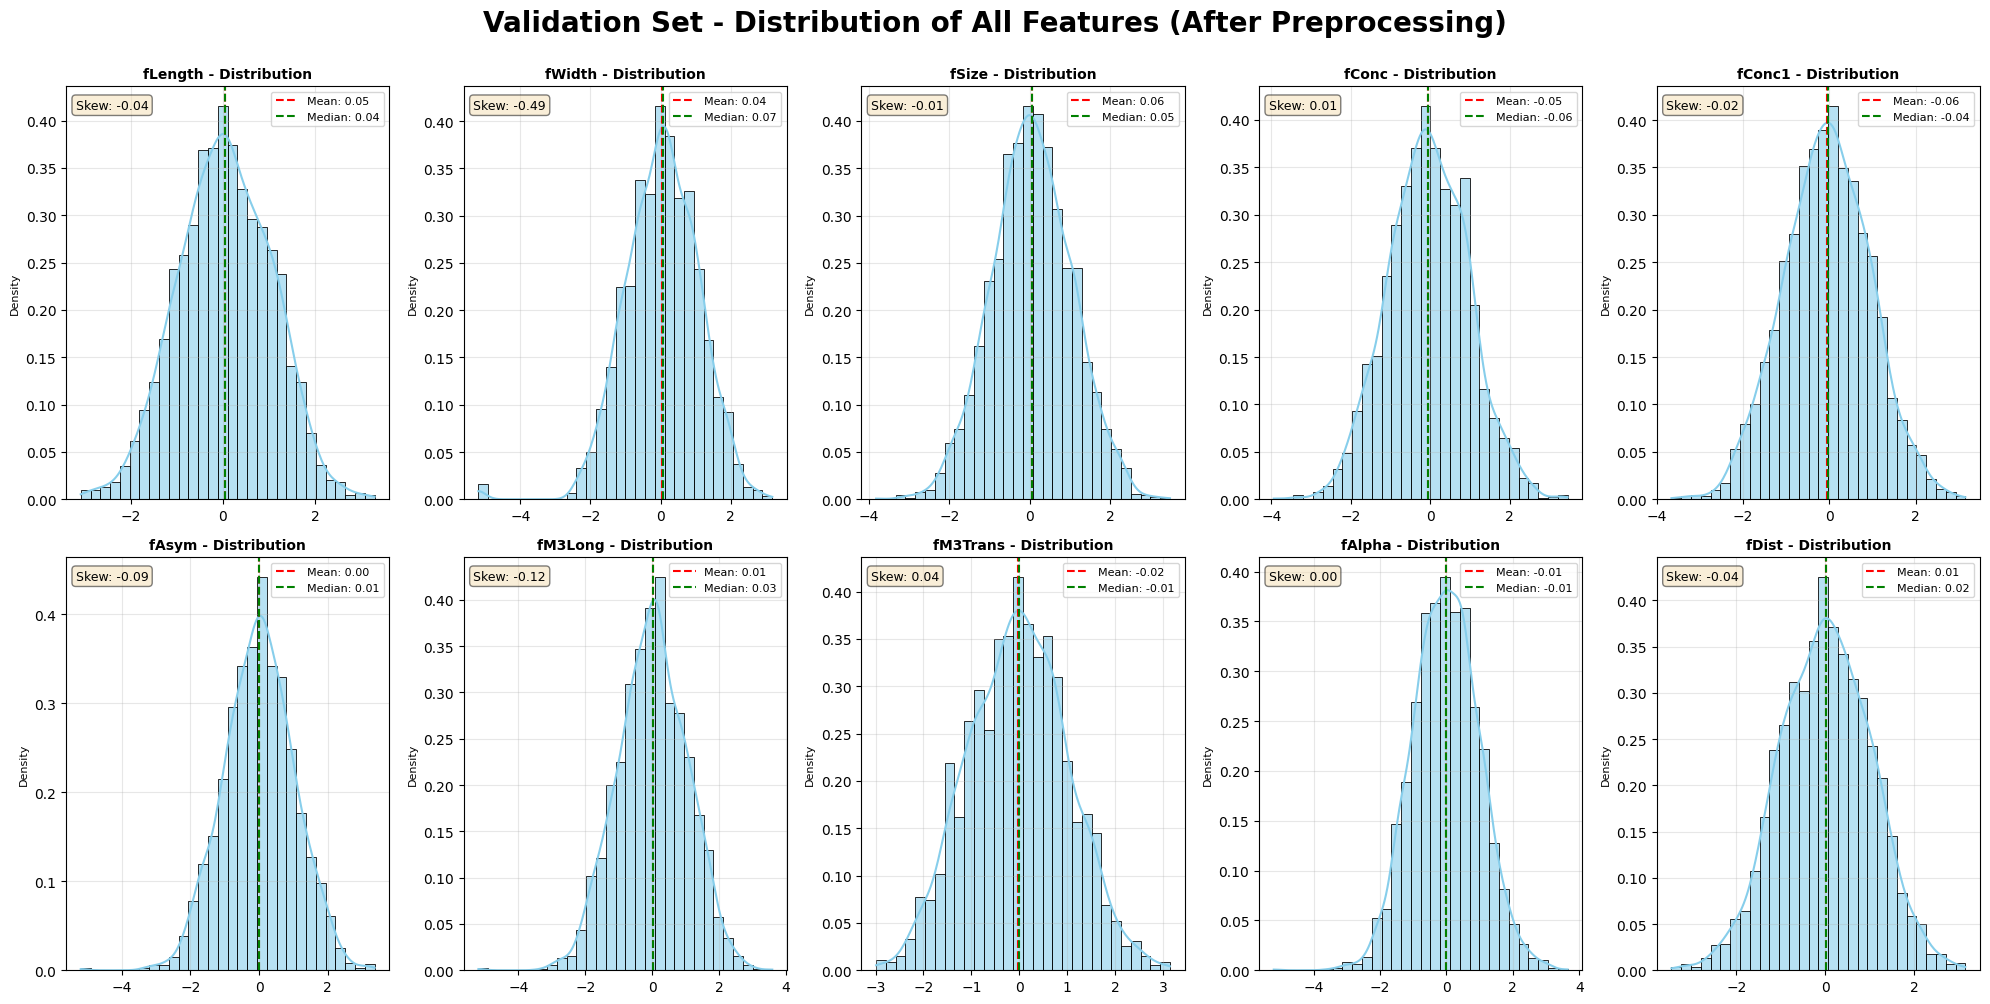

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


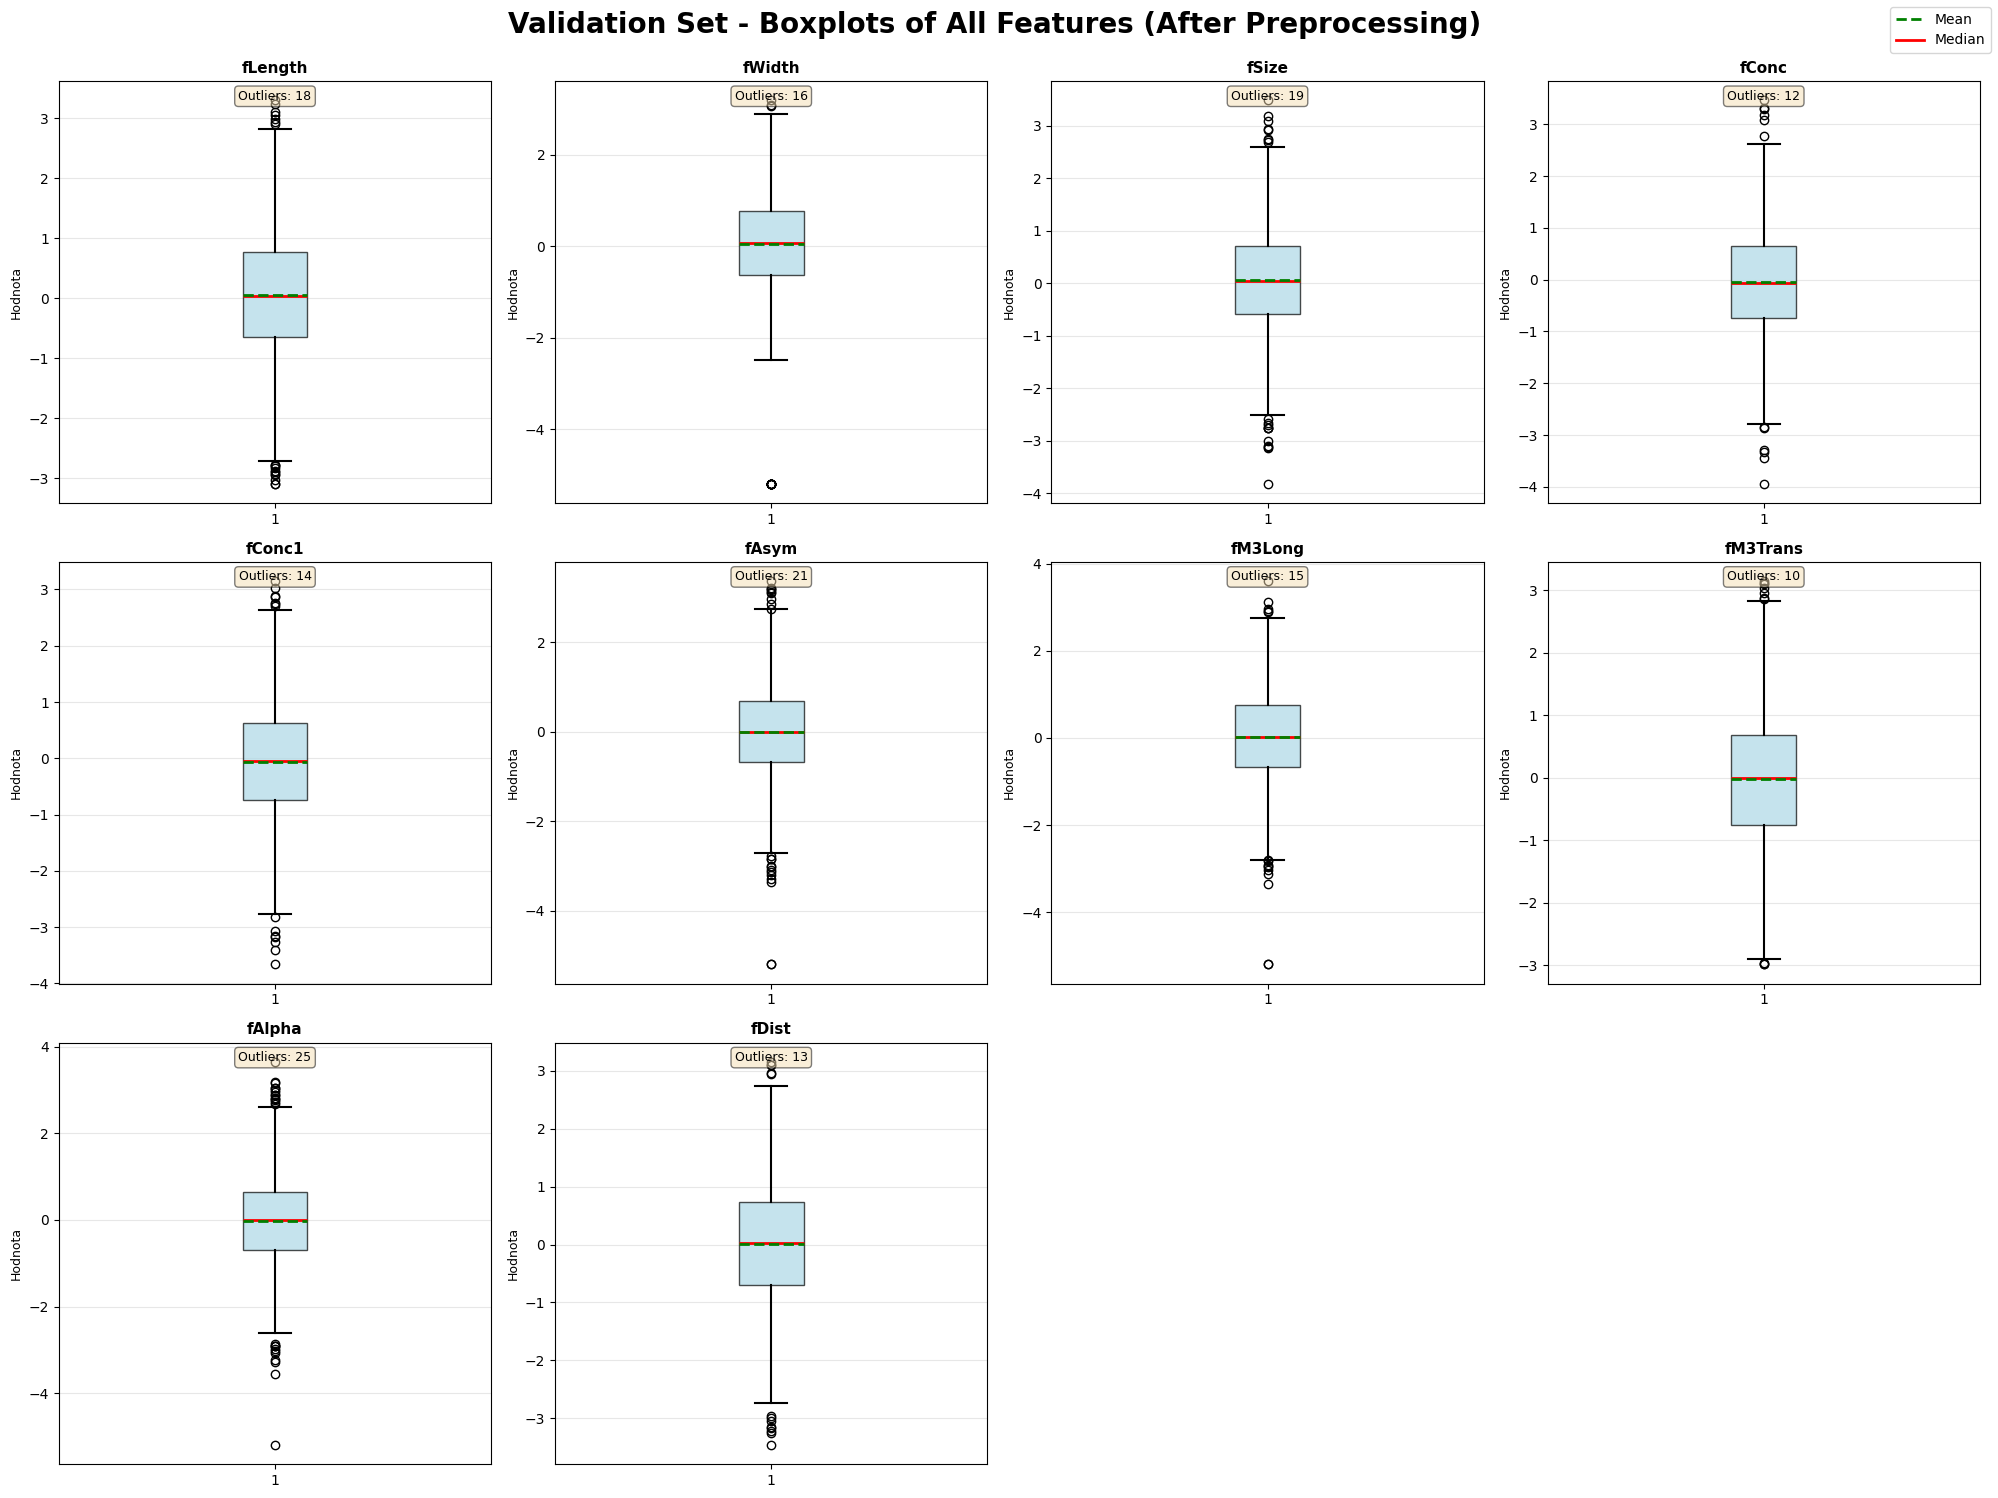


VISUALIZING TEST SET (After Preprocessing)
Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


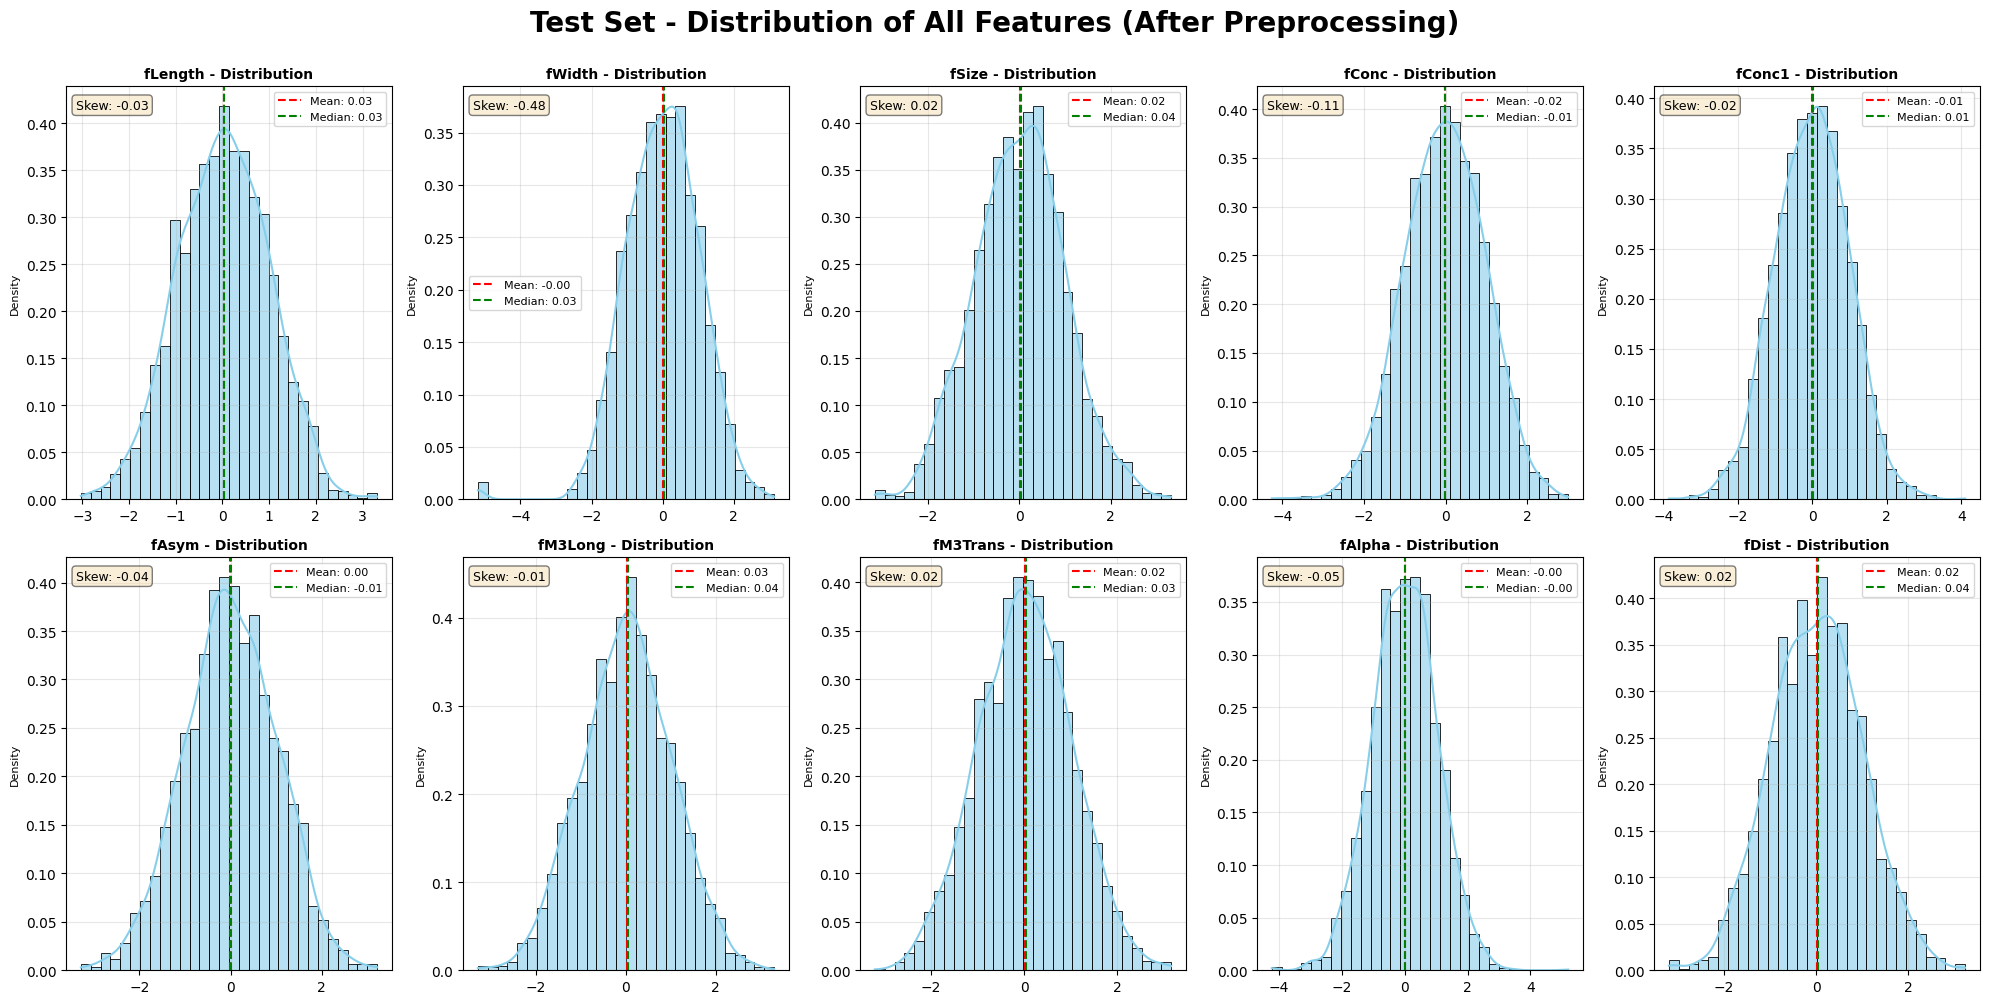

Počet vizualizovaných atribútov: 10
Atribúty: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


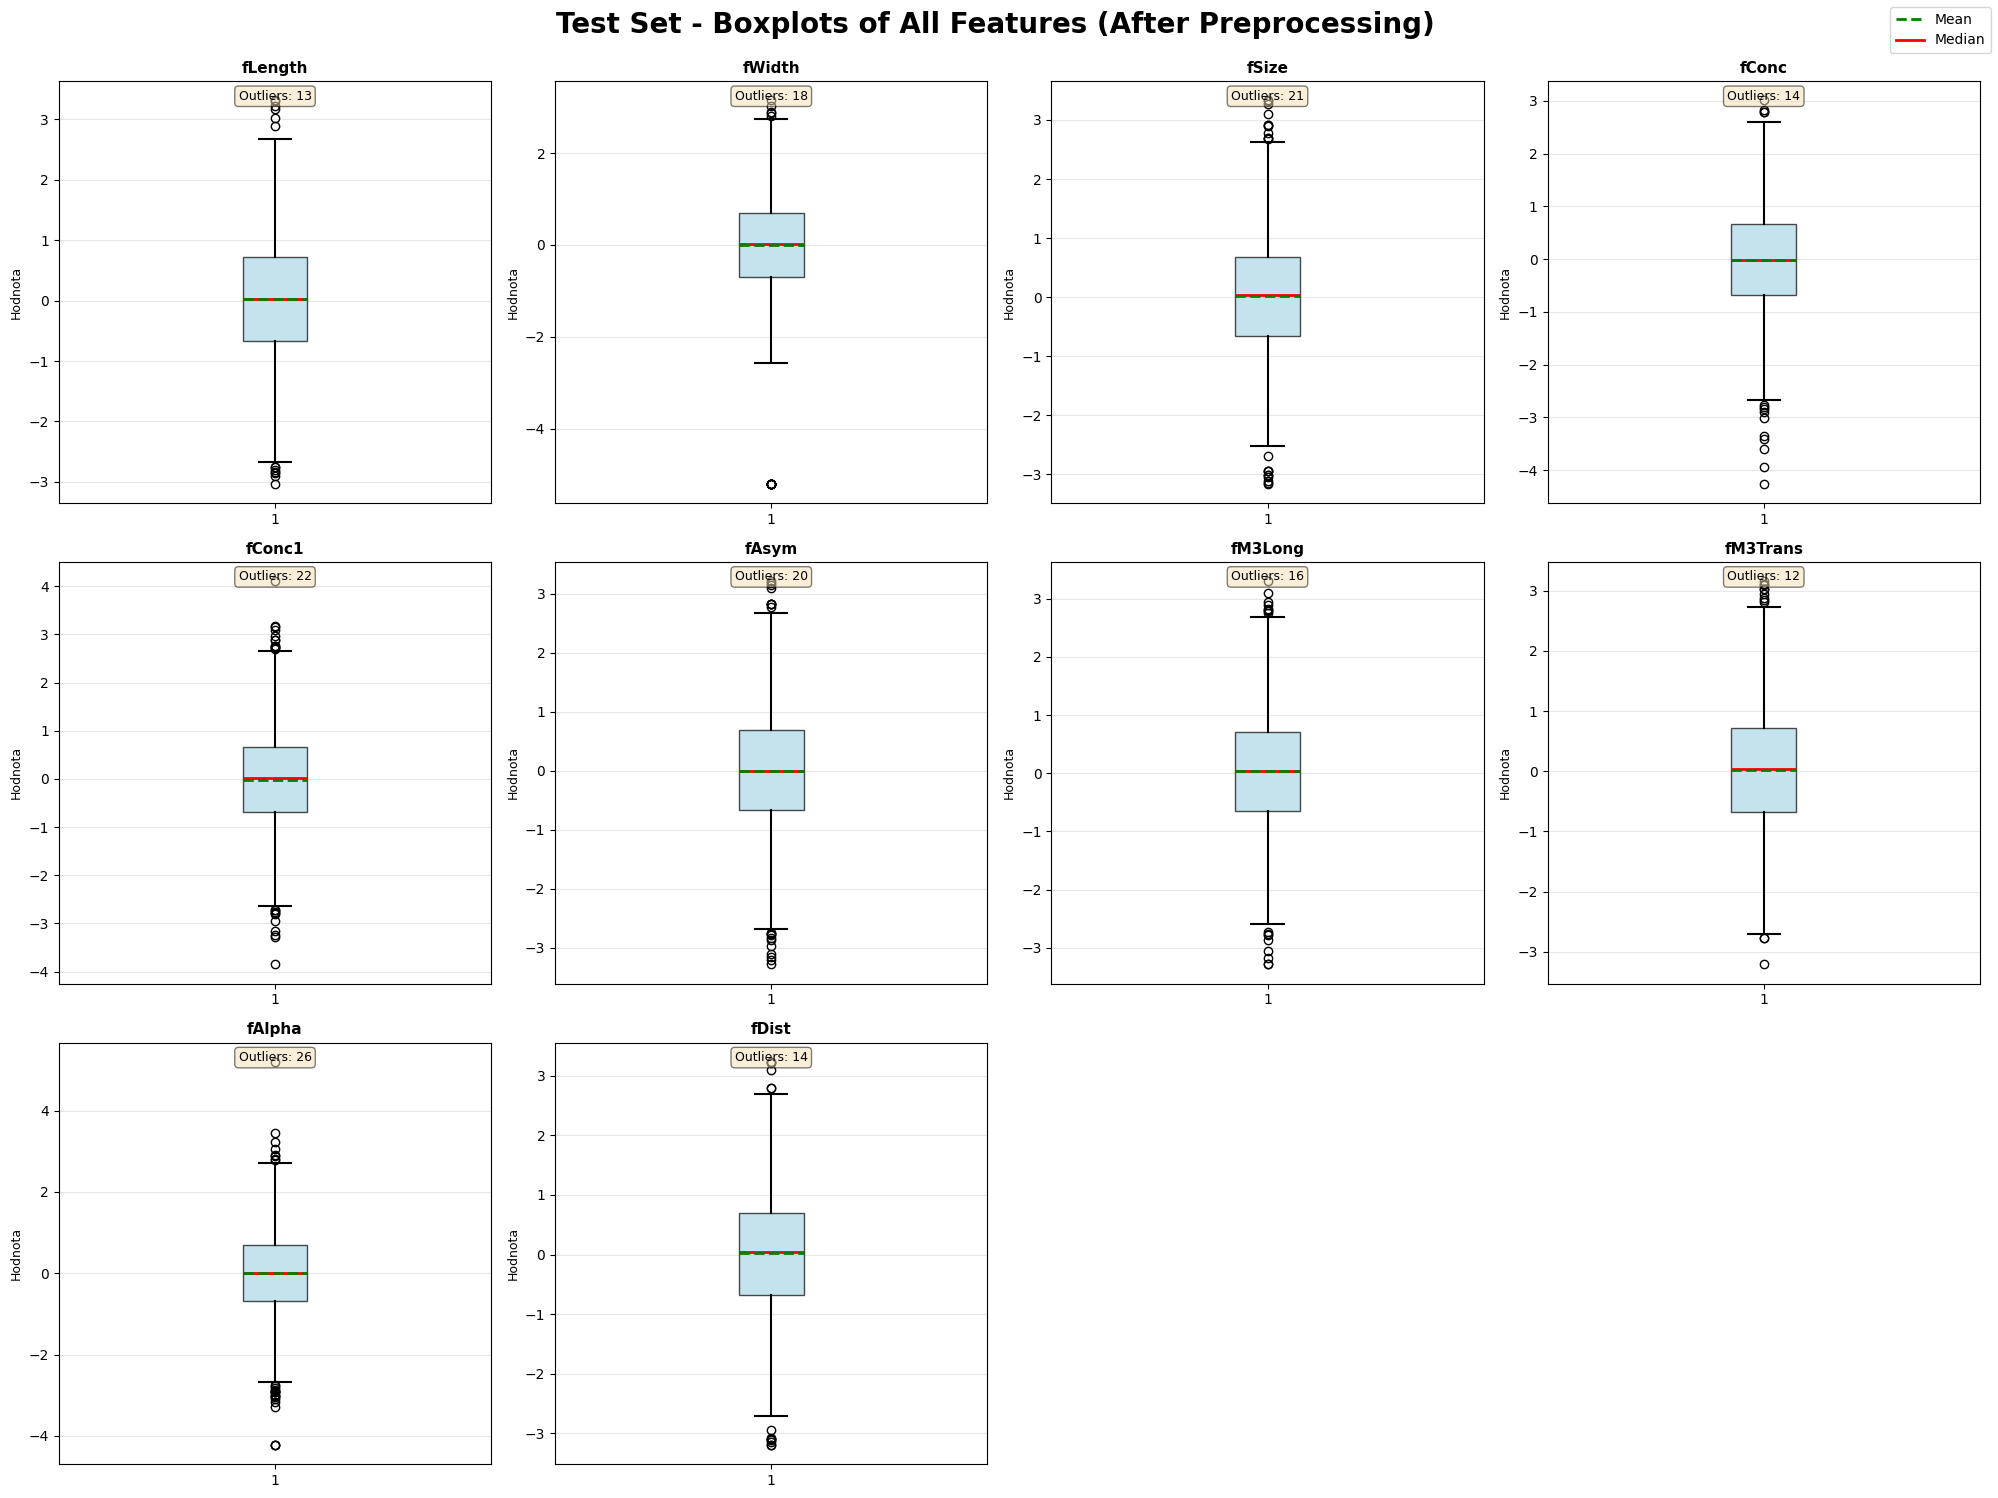

In [16]:
import matplotlib.pyplot as plt
from plotting_tools import visualize_distributions, visualize_outliers_boxplots

# Create DataFrames from processed data for visualization
X_train_df = pd.DataFrame(X_train_processed, columns=X_train.columns)
X_val_df = pd.DataFrame(X_val_processed, columns=X_val.columns)
X_test_df = pd.DataFrame(X_test_processed, columns=X_test.columns)

# Add class labels for split visualization
X_train_df['class'] = y_train.values
X_val_df['class'] = y_val.values
X_test_df['class'] = y_test.values

print("=" * 80)
print("VISUALIZING TRAINING SET (After Preprocessing)")
print("=" * 80)

# Visualize distributions of training set
fig1 = visualize_distributions(
    X_train_df,
    exclude_cols=['class'],
    title='Training Set - Distribution of All Features (After Preprocessing)',
    figsize=(20, 10),
    n_cols=5
)
plt.show()

# Visualize outliers in training set
fig2 = visualize_outliers_boxplots(
    X_train_df,
    exclude_cols=['class'],
    title='Training Set - Boxplots of All Features (After Preprocessing)',
    figsize=(20, 5)
)
plt.show()

print("\n" + "=" * 80)
print("VISUALIZING VALIDATION SET (After Preprocessing)")
print("=" * 80)

# Visualize distributions of validation set
fig3 = visualize_distributions(
    X_val_df,
    exclude_cols=['class'],
    title='Validation Set - Distribution of All Features (After Preprocessing)',
    figsize=(20, 10),
    n_cols=5
)
plt.show()

# Visualize outliers in validation set
fig4 = visualize_outliers_boxplots(
    X_val_df,
    exclude_cols=['class'],
    title='Validation Set - Boxplots of All Features (After Preprocessing)',
    figsize=(20, 5)
)
plt.show()

print("\n" + "=" * 80)
print("VISUALIZING TEST SET (After Preprocessing)")
print("=" * 80)

# Visualize distributions of test set
fig5 = visualize_distributions(
    X_test_df,
    exclude_cols=['class'],
    title='Test Set - Distribution of All Features (After Preprocessing)',
    figsize=(20, 10),
    n_cols=5
)
plt.show()

# Visualize outliers in test set
fig6 = visualize_outliers_boxplots(
    X_test_df,
    exclude_cols=['class'],
    title='Test Set - Boxplots of All Features (After Preprocessing)',
    figsize=(20, 5)
)
plt.show()

## Part 3 - Model Building